<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据探索" data-toc-modified-id="数据探索-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据探索</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#label部分" data-toc-modified-id="label部分-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>label部分</a></span></li><li><span><a href="#text部分" data-toc-modified-id="text部分-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>text部分</a></span></li></ul></li></ul></li></ul></div>

## 数据探索

#### label部分

In [1]:
import pandas as pd 
import numpy as np
import sklearn as sl
import matplotlib.pyplot as plt
import seaborn as sn
import torch

In [2]:
train_data = pd.read_csv('train_set.csv',sep='\t')

In [3]:
train_data.head()

,label,text
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   200000 non-null  int64 
 1   text    200000 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [5]:
train_data.describe()

,label
count,200000.000000
mean,3.210950
std,3.084955
min,0.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,13.000000


　　从基本信息来看，csv每一行有label，text两列，label是int格式，text是obj格式的，label和text都没有null的值，目前看来数据基本都是可用的，但是从describe返回的结果看，label的范围为0-13，又因为label的类型为int，所以总共是14个标签。但是反应出来一个问题是标签的分布不是均匀的，初步来看，有25%的数据标签是0和1，有50%的数据标签是0和1和2，标签整体的均值是3。为了了解具体的分布状态，画个正态分布图看看

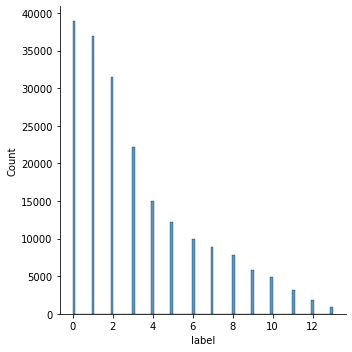

In [6]:
sn.displot(train_data['label'])

In [7]:
pd.concat([train_data.label.value_counts(),train_data.label.value_counts(normalize=True)],axis=1)

,label,label
0,38918,0.194590
1,36945,0.184725
2,31425,0.157125
3,22133,0.110665
4,15016,0.075080
5,12232,0.061160
6,9985,0.049925
7,8841,0.044205
8,7847,0.039235
9,5878,0.029390


　　上面是各个标签出现的次数，以及他们各自占整体标签数量的比例，其中最高的是标签0，占总体数据比例接近20%，最低的是标签13，占总体数据比例不到1%，差了接近20倍。如果直接训练，应该会导致整个模型偏重于让数据占比高的标签预测正确，而数据占比小的标签预测失败，因为这样对于模型来说可以快速的降低损失提高预测正确率。  
  
　　为了避免这种情况发生，可以进行一下权重分配。关于权重分配的实现以及其和损失计算的关系，见pytorch库的第11篇文章，这里放具体实现

In [8]:
def get_weight(label):
    '''适用于以列表形式表示的label数据'''
    import torch
    
    #计算所有各类别拥有的数据个数
    tmp_dict = {}
    count_dict = {}
    for i in label:
        num=0
        if i not in tmp_dict.keys():
            for j in label:
                if j==i:
                    num+=1
            tmp_dict[i] = num
    for class_index in sorted(tmp_dict.keys()):
        count_dict[class_index] = tmp_dict[class_index]
        
    #计算所有类别的个数(先统一除以平均值，避免乘积太大)的乘积，生成对应类别的权重值
    tmp = 1
    mean_count=sum(count_dict.values())/len(count_dict.values())
    for value in count_dict.values():
        tmp = tmp*(value/mean_count)
    weight_list = [tmp/value for value in count_dict.values()]
    
    #把权重值缩放到0-1之间
    max_weight = max(weight_list)
    weight = torch.Tensor([value/max_weight for value in weight_list])
    
    print('生成的权重分布为：\n',weight)
    print('各个分类对应的数据数量：\n',count_dict)
    
    return weight,count_dict

In [9]:
train_label = list(train_data.label.to_numpy())
train_label_weight,_ = get_weight(train_label)

生成的权重分布为：
 tensor([0.0233, 0.0246, 0.0289, 0.0410, 0.0605, 0.0742, 0.0909, 0.1027, 0.1157,
        0.1545, 0.1846, 0.2900, 0.4986, 1.0000])
各个分类对应的数据数量：
 {0: 38918, 1: 36945, 2: 31425, 3: 22133, 4: 15016, 5: 12232, 6: 9985, 7: 8841, 8: 7847, 9: 5878, 10: 4920, 11: 3131, 12: 1821, 13: 908}


#### text部分

In [3]:
train_text = train_data.text

In [11]:
train_text.head(),train_text.shape

(0    2967 6758 339 2021 1854 3731 4109 3792 4149 15...
 1    4464 486 6352 5619 2465 4802 1452 3137 5778 54...
 2    7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
 3    7159 948 4866 2109 5520 2490 211 3956 5520 549...
 4    3646 3055 3055 2490 4659 6065 3370 5814 2465 5...
 Name: text, dtype: object,
 (200000,))

In [12]:
print(type(train_text[0]))
train_text[0]

<class 'str'>


'2967 6758 339 2021 1854 3731 4109 3792 4149 1519 2058 3912 2465 2410 1219 6654 7539 264 2456 4811 1292 2109 6905 5520 7058 6045 3634 6591 3530 6508 2465 7044 1519 3659 2073 3750 3731 4109 3792 6831 2614 3370 4269 3370 486 5770 4109 4125 3750 5445 2466 6831 6758 3743 3630 1726 2313 5906 826 4516 657 900 1871 7044 3750 2967 3731 1757 1939 648 2828 4704 7039 3706 3750 965 2490 7399 3743 2145 2407 7451 3775 6017 5998 1641 299 4704 2621 7029 3056 6333 433 648 1667 1099 900 2289 1099 648 5780 220 7044 1279 7426 4269 3750 2967 6758 6631 3099 2205 7305 2620 5977 3750 3329 1793 6666 2042 3193 4149 1519 7039 3706 2446 5399 648 4124 2058 3912 248 3193 2252 5649 2212 4939 7239 3310 4525 2400 900 5770 4109 4125 7044 4921 265 1397 4699 1699 669 6407 3750 1271 1271 4741 669 4659 3870 4030 4167 5338 25 3466 6909 4417 1859 3750 1465 7194 648 3938 1571 848 6986 827 2124 3750 1991 7444 7037 2729 908 6308 3750 1889 6810 4190 591 5598 2289 2109 6831 6407 2400 5410 517 900 25 3731 4109 3792 4128 1679 4811 

In [13]:
max_len = 0
min_len = 1000000
max_i = 0
min_i = 0
max_word_id = 0
min_word_id = 1000000
for i in range(len(train_text)):
    tmp_list = [int(value) for value in train_text[i].split()]
    if max(tmp_list)>max_word_id:
        max_word_id = max(tmp_list)
    if min(tmp_list)<min_word_id:
        min_word_id = min(tmp_list)
    if len(tmp_list)>max_len:
        max_len=len(tmp_list)
        max_i = i
    if len(tmp_list)<min_len:
        min_len=len(tmp_list)
        min_i = i
print('文本最大的长度为：',max_len,'编号索引为：',max_i)
print('文本最小的长度为：',min_len,'编号索引为：',min_i)
print('max_word_id:',max_word_id)
print('min_word_id:',min_word_id)

文本最大的长度为： 57921 编号索引为： 115630
文本最小的长度为： 2 编号索引为： 11863
max_word_id: 7549
min_word_id: 0


In [14]:
train_text[min_i]

'2465 1633'

In [15]:
train_text[max_i]

'5602 2073 4464 3700 4853 299 6357 151 2859 584 1920 151 2446 2029 384 7495 2435 4568 5915 134 2465 5602 2073 4464 3700 4853 584 1920 3750 4679 4650 2289 6357 3223 913 299 6357 151 2859 2252 4211 5598 151 2446 900 5948 4516 4939 151 2446 6825 3915 7539 299 6501 2538 2506 2693 6713 5612 7255 5288 5491 299 6501 2662 1722 3961 5036 4216 4811 330 151 2859 619 3659 3370 4464 4464 1519 5602 2073 4464 2799 4853 2012 5176 1292 2211 4866 1292 5677 431 5537 3800 3068 1292 2211 4214 5677 2738 5537 3800 3750 3800 2791 6695 2791 1363 4490 1871 4516 872 2791 7539 6122 5560 1363 4490 151 2859 3659 3370 4464 3370 1519 4480 3772 4786 7543 3137 3335 2695 7539 669 7543 3137 3750 669 4407 2380 900 1036 5560 1363 4490 151 2859 3659 3370 4464 3370 1519 1519 4480 3530 2446 340 6825 3915 900 2107 5560 1363 4490 3193 515 299 6501 299 3800 3800 7261 2282 5537 5526 5612 4811 330 151 2859 648 2791 2695 900 4321 5560 1363 4490 151 2859 3659 3370 4464 4464 1519 1070 6122 2621 4480 3530 2446 900 5788 5560 3166 7239 

　　每一个text数据是一个string，从上面的分析来看，一个text中最长有57921个字符，最短是2个字符，字符token的最小编号是0，最大编号是7549。  
  
　　从上面的数据来看，训练的初步思路，可以将每个text转换成一个1D的Tensor，使用Conv1d进行多次卷积操作，最后进行一次全连接将每个text转换成0-13个分类，以f1_score作为评价指标，进行优化

　　看一下不同长度的text的占比情况

In [4]:
text_len_list = []
for i in range(len(train_text)):
    text_len = len(train_text[i].split())
    text_len_list.append(text_len)

In [7]:
#96的数据的长度小于2674
new_list = [x for x in text_len_list]
new_list.sort()
print(new_list[192000])

2674


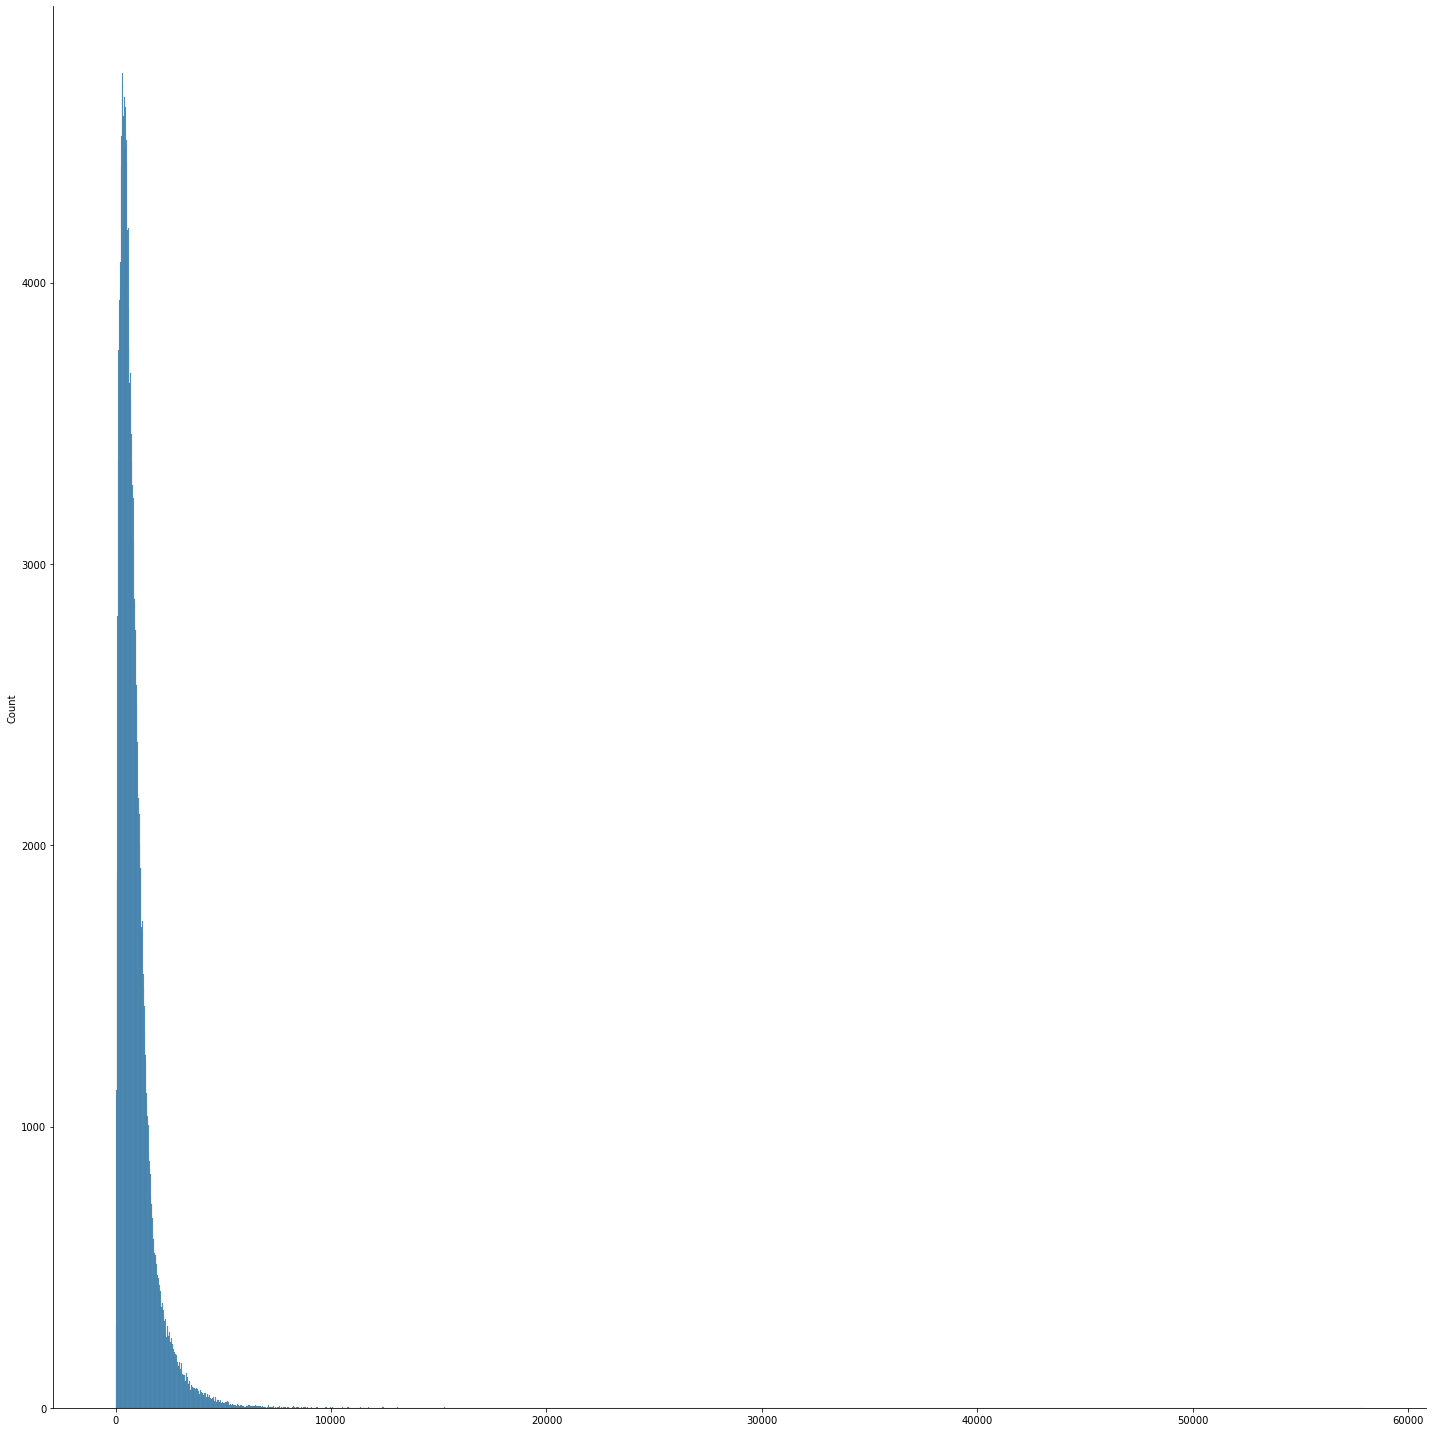

In [25]:
sn.displot(text_len_list,height=20)

In [4]:
label = train_data.label
max_label = 0
min_label = 100
for i in range(len(label)):
    if label[i] > max_label:
        max_label = label[i]
    if label[i] < min_label:
        min_label = label[i]
        
print(max_label,min_label)

13 0
